In [1]:
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np

In [2]:
sampling_methods = ['random', 'uncertainty', "BGADL", "OpenMax", "Core_set", 'certainty', 'active_query', 'AV_temperature', 'test_query']
datasets = {'Tiny-Imagenet': {'init_percent': 8, 'known_class': [40], 'batch': [200, 400, 600, 1500]},
            'cifar100': {'init_percent': 8, 'known_class': [20], 'batch': [200, 400, 600, 1500]},
            'cifar10': {'init_percent': 1, 'known_class': [2], 'batch': [200, 400, 600, 1500]}}

In [3]:
def load_pkl_files(dataset_name, known_class, batch_size=None):
    pkl_files = {method: [] for method in sampling_methods}
    log_al_folder = 'log_AL/'
    for file in os.listdir(log_al_folder):
        if file.endswith('.pkl') and f"{dataset_name}_" in file and f"known{known_class}" in file:
            if batch_size is not None and f"batch{batch_size}_" not in file:
                continue
            for method in sampling_methods:
                if method in file:
                    if "_per_round_query_index" in file:
                        continue
                    pkl_files[method].append(os.path.join(log_al_folder, file))
                    break
    return pkl_files

In [4]:
def plot_graphs(group_name, acc_list, precision_list, recall_list, acc_std_list, precision_std_list, recall_std_list, batch_size):
    query_numbers = list(range(len(acc_list[0])))

    plt.figure()
    for i, (acc, acc_std) in enumerate(zip(acc_list, acc_std_list)):
        label = sampling_methods[i] if sampling_methods[i] != 'active_query' else 'Proposed'
        plt.plot(query_numbers, acc, label=label)
        plt.fill_between(query_numbers, np.array(acc) - 0.8 * np.array(acc_std), np.array(acc) + 0.8 * np.array(acc_std), alpha=0.2)
    plt.xlabel('Query Numbers')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy for {group_name} Batch {batch_size}')
    plt.legend()
    plt.show()

    plt.figure()
    for i, (precision, precision_std) in enumerate(zip(precision_list, precision_std_list)):
        label = sampling_methods[i] if sampling_methods[i] != 'active_query' else 'Proposed'
        plt.plot(query_numbers, precision, label=label)
        plt.fill_between(query_numbers, np.array(precision) - 0.8 * np.array(precision_std), np.array(precision) + 0.8 * np.array(precision_std), alpha=0.3)
    plt.xlabel('Query Numbers')
    plt.ylabel('Precision')
    plt.title(f'Precision for {group_name} Batch {batch_size}')
    plt.legend()
    plt.show()

    plt.figure()
    for i, (recall, recall_std) in enumerate(zip(recall_list, recall_std_list)):
        label = sampling_methods[i] if sampling_methods[i] != 'active_query' else 'Proposed'
        plt.plot(query_numbers, recall, label=label)
        plt.fill_between(query_numbers, np.array(recall) - 0.8 * np.array(recall_std), np.array(recall) + 0.8 * np.array(recall_std), alpha=0.3)
    plt.xlabel('Query Numbers')
    plt.ylabel('Recall')
    plt.title(f'Recall for {group_name} Batch {batch_size}')
    plt.legend()
    plt.show()

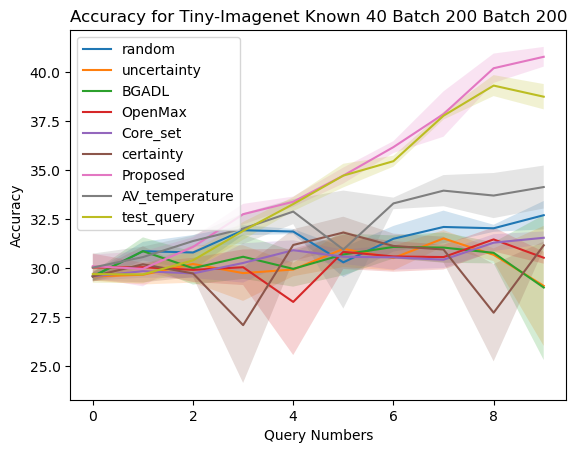

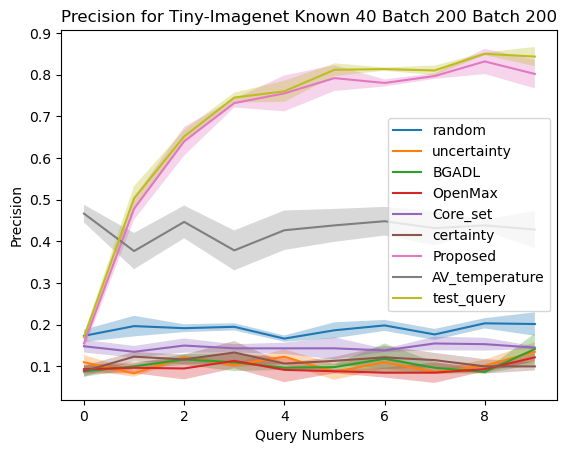

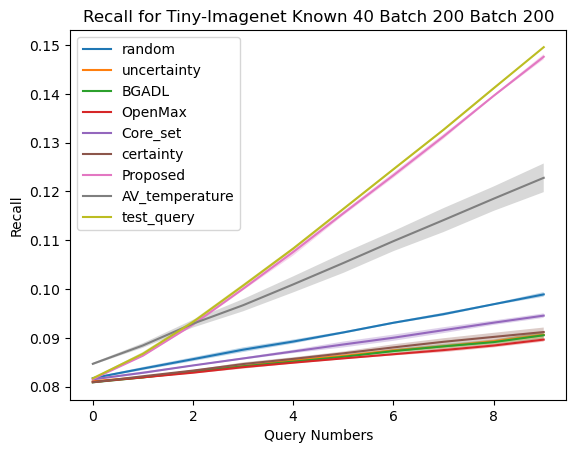

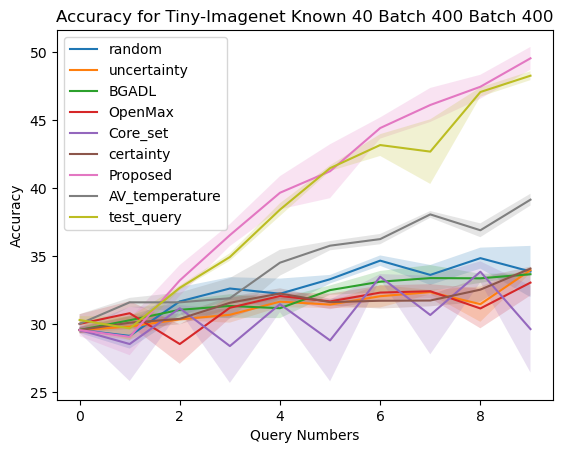

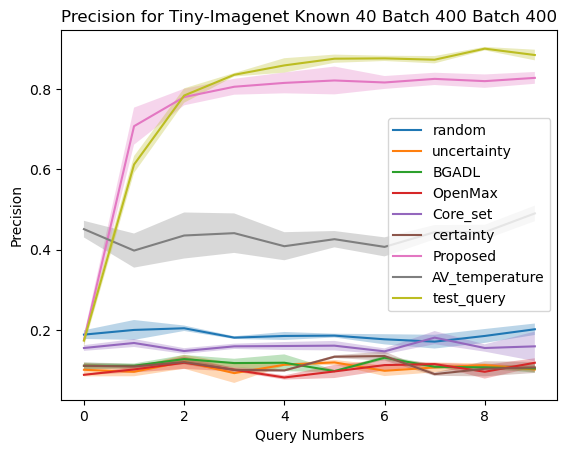

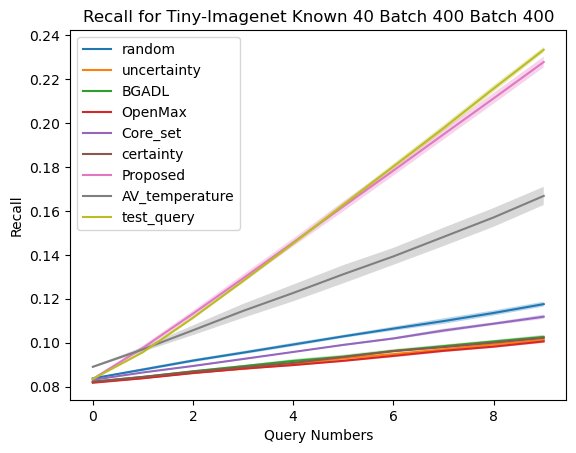

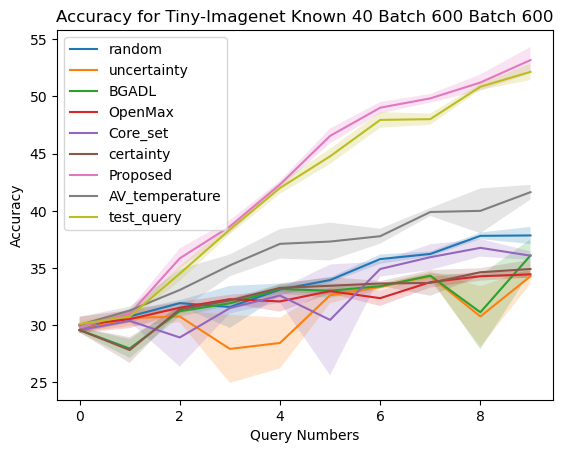

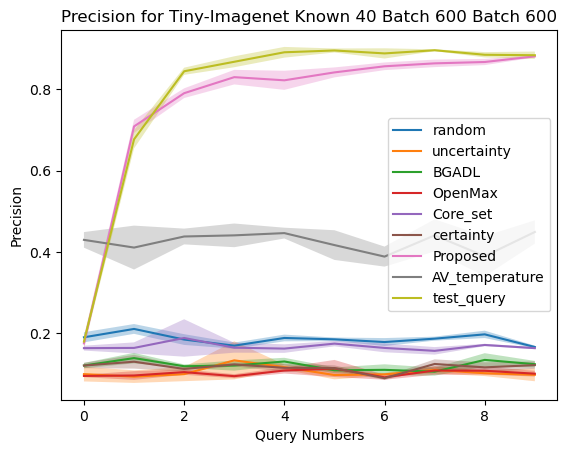

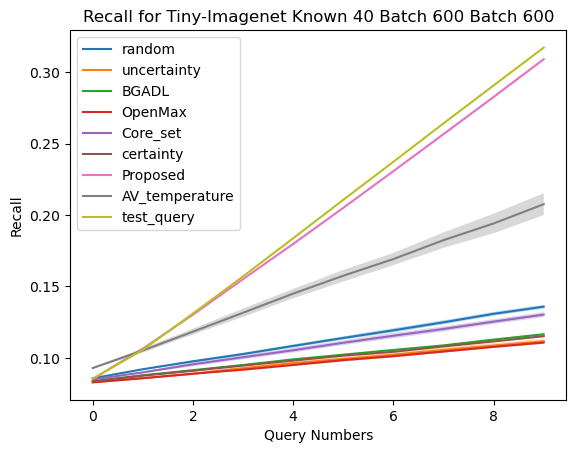

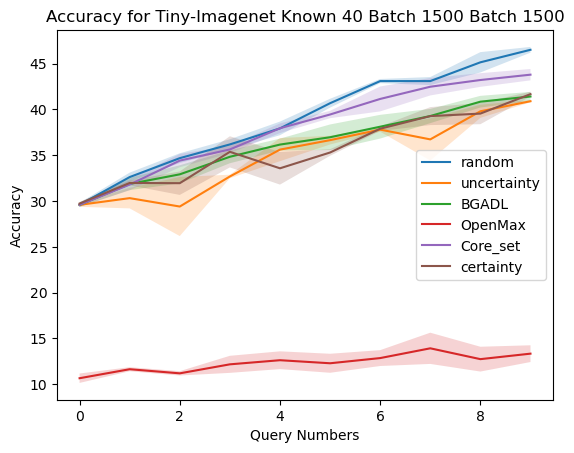

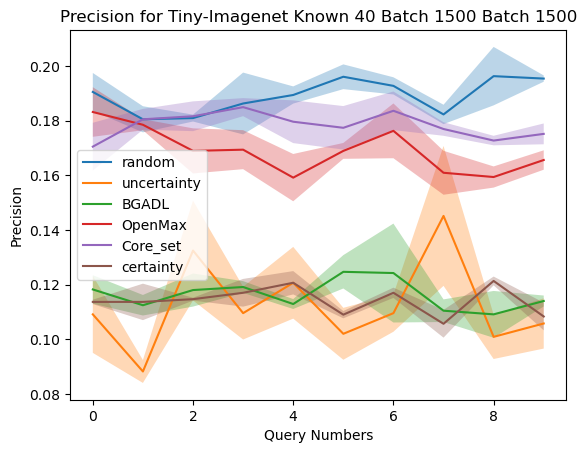

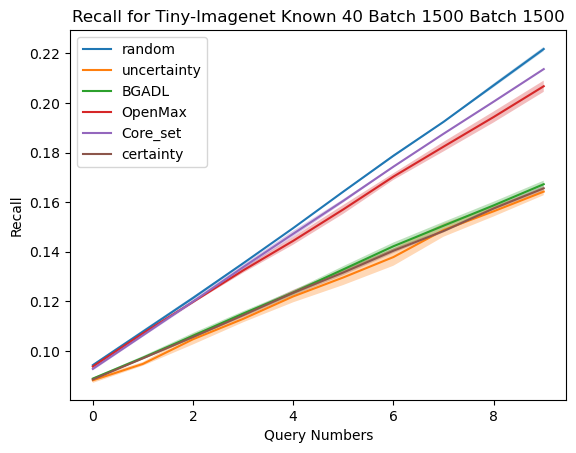

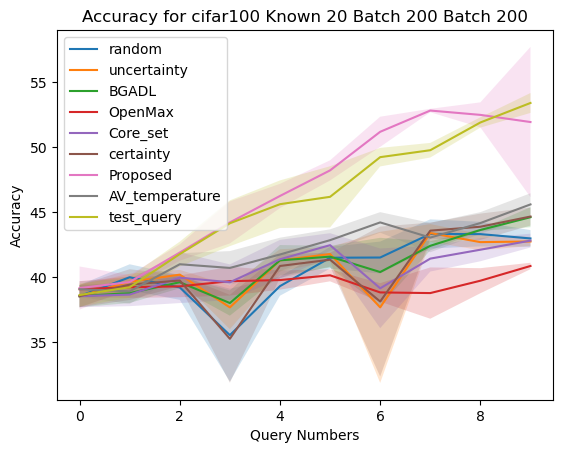

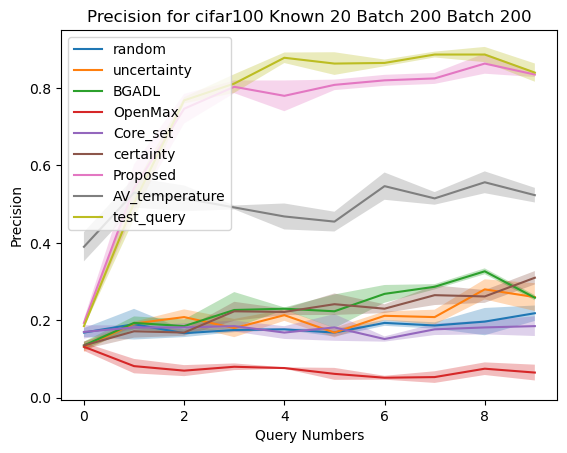

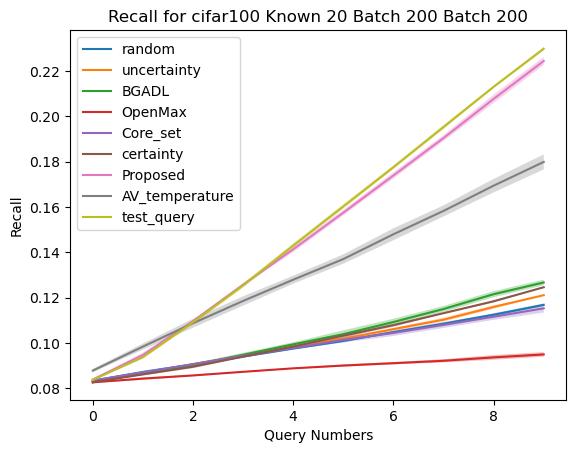

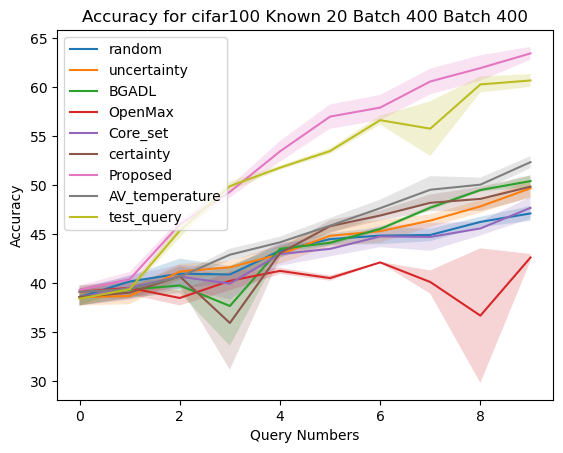

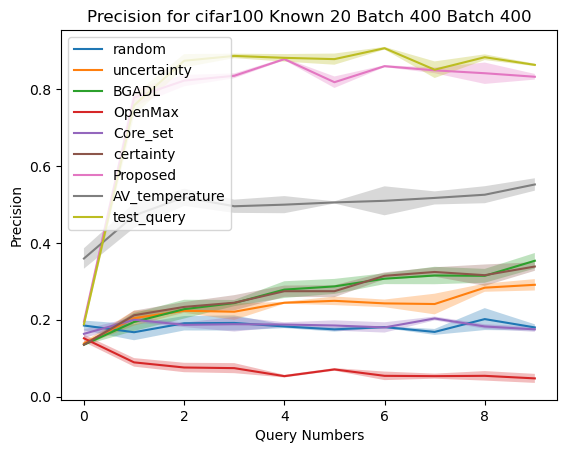

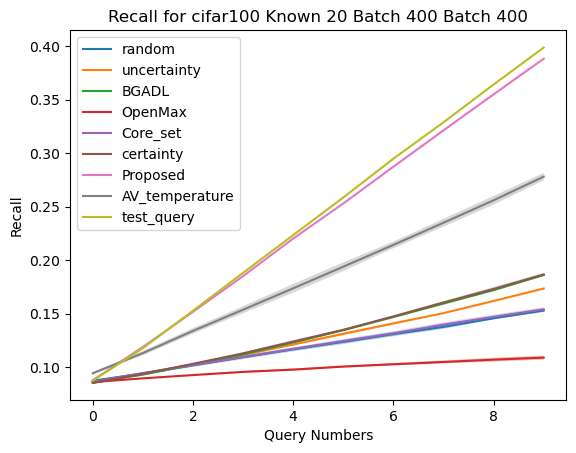

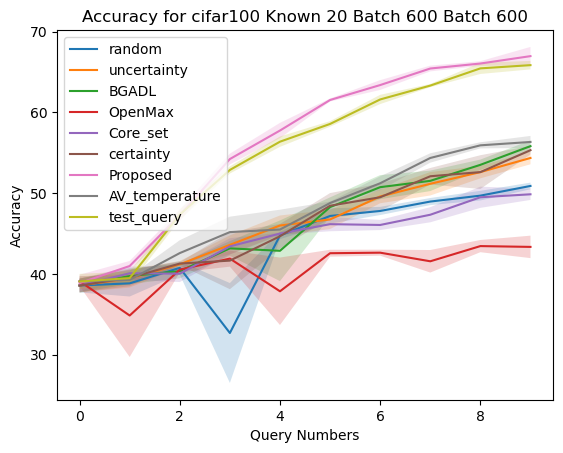

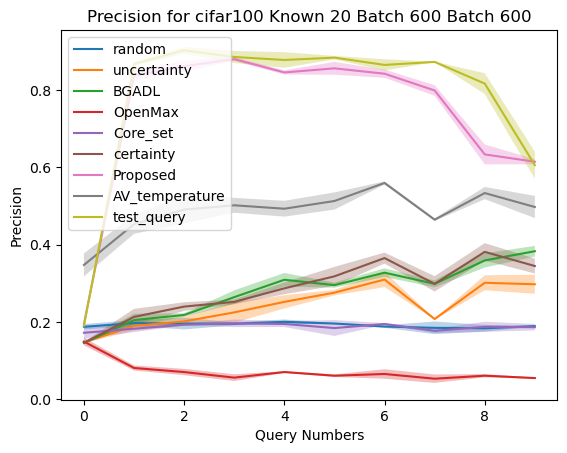

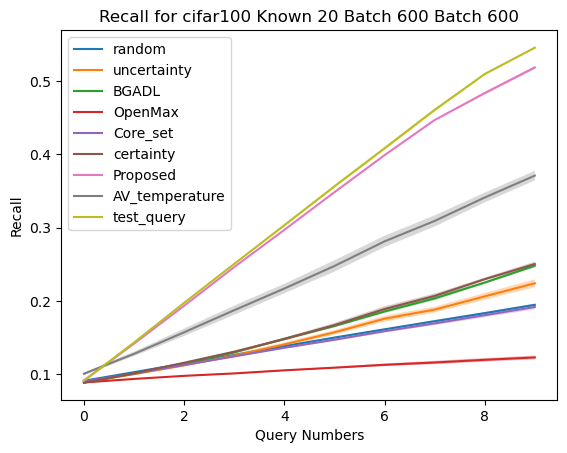

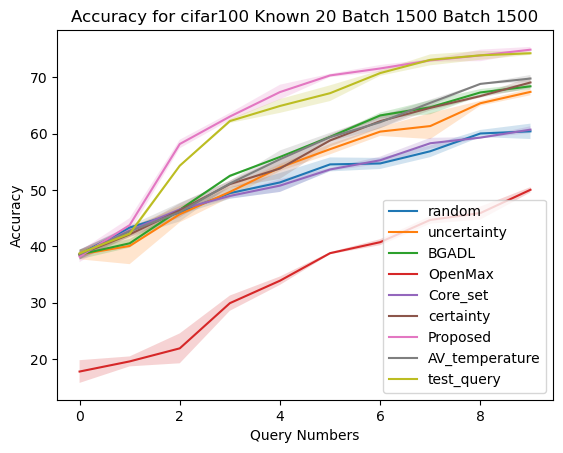

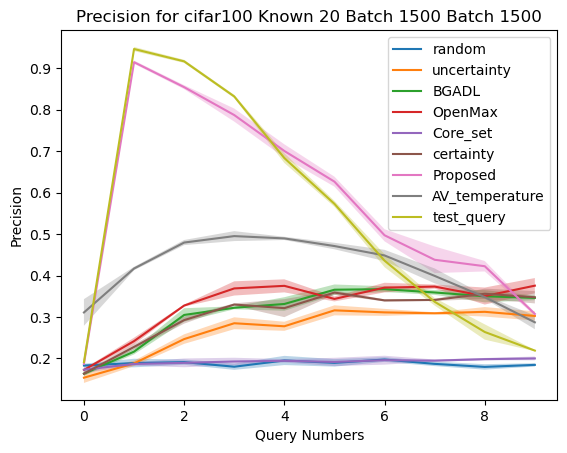

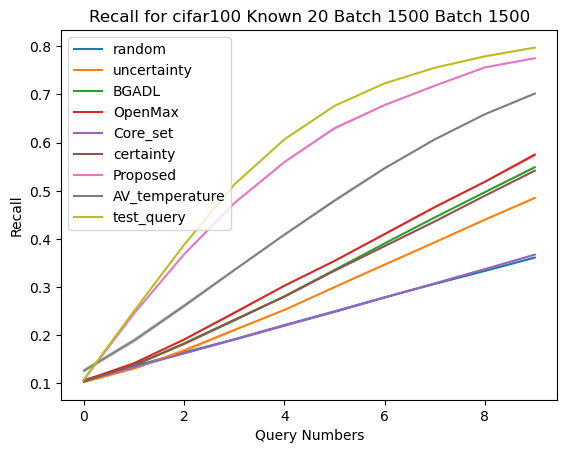

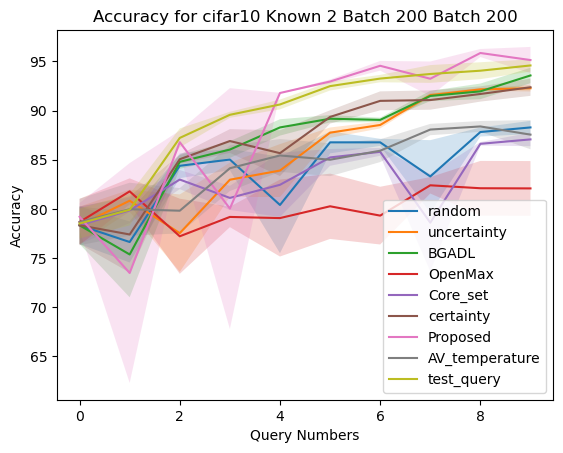

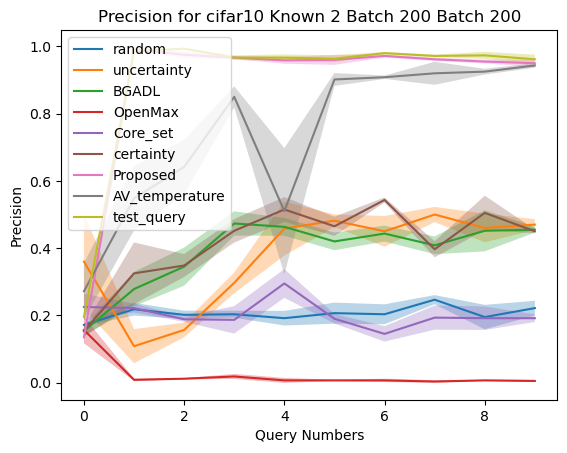

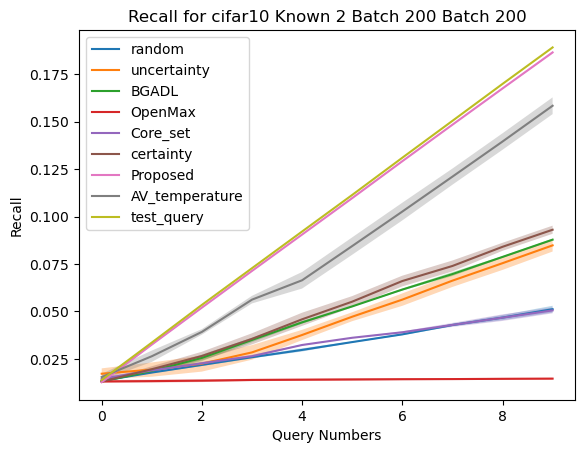

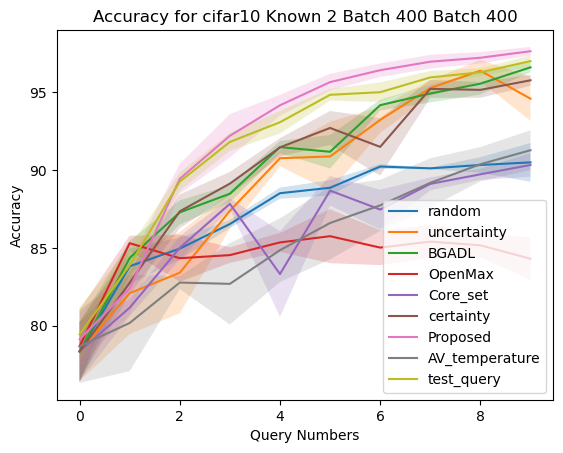

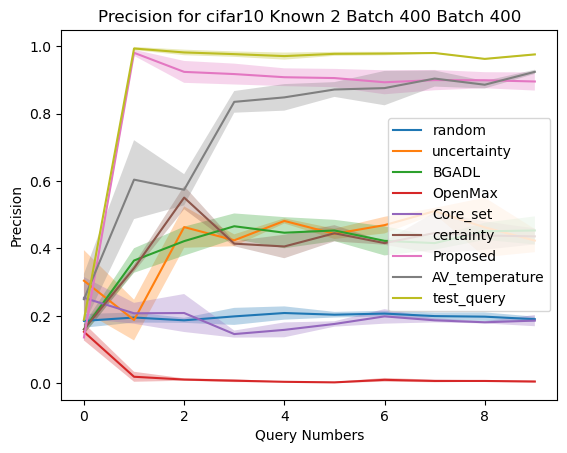

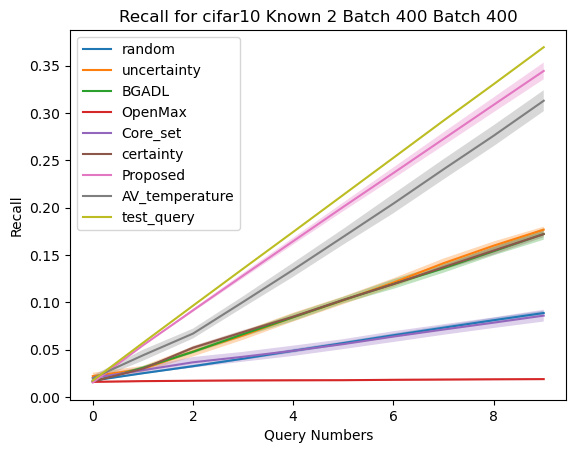

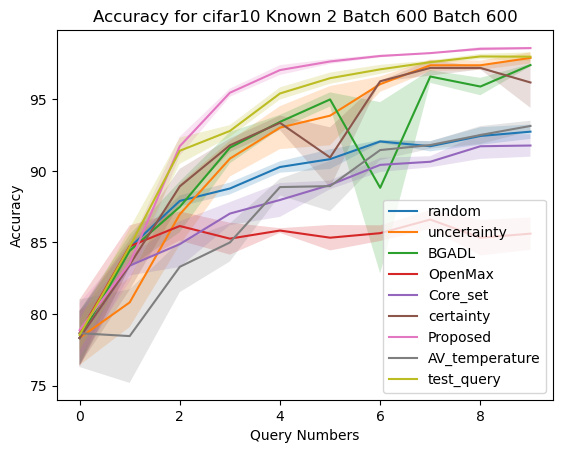

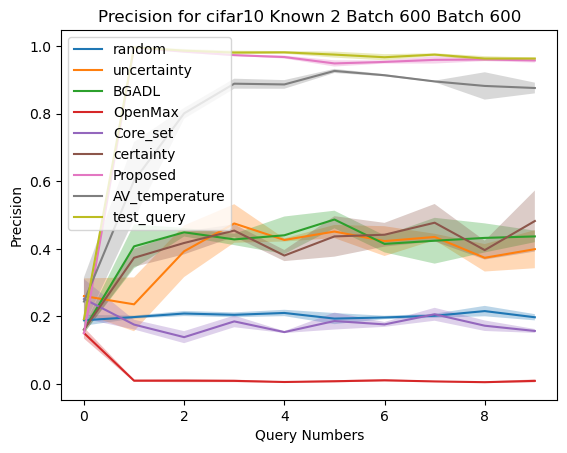

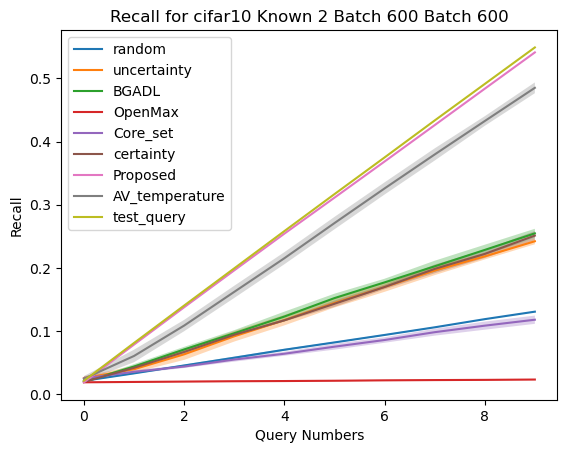

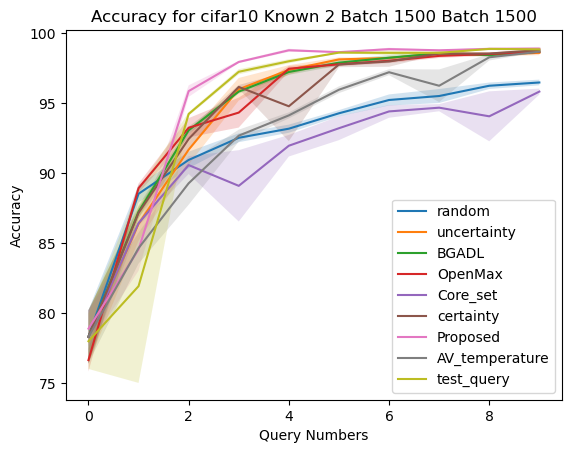

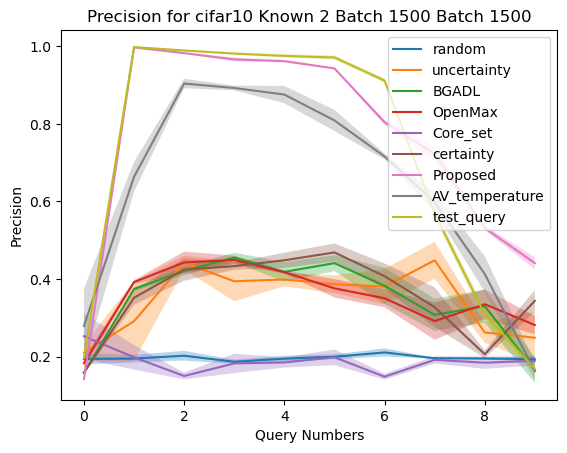

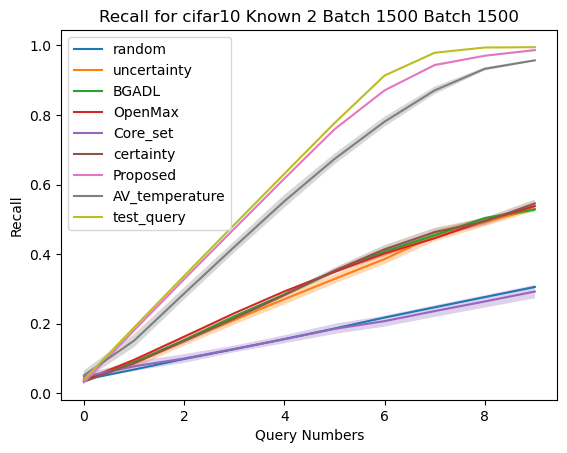

In [5]:
for dataset_name, dataset_info in datasets.items():
    for known_class in dataset_info['known_class']:
        for batch_size in dataset_info['batch']:
            group_name = f"{dataset_name} Known {known_class} Batch {batch_size}"
            pkl_files_dict = load_pkl_files(dataset_name, known_class, batch_size)
            acc_list, precision_list, recall_list = [], [], []
            acc_std_list, precision_std_list, recall_std_list = [], [], []

            for method, files in pkl_files_dict.items():
                acc_vals, precision_vals, recall_vals = [], [], []
                for file in files:
                    with open(file, 'rb') as f:
                        data = pickle.load(f)
                        acc_vals.append([data['Acc'][i] for i in data['Acc']])
                        precision_vals.append([data['Precision'][i] for i in data['Precision']])
                        recall_vals.append([data['Recall'][i] for i in data['Recall']])

                if acc_vals:
                    num_seeds = len(files)
                    acc_avg = np.mean(acc_vals, axis=0).tolist()
                    precision_avg = np.mean(precision_vals, axis=0).tolist()
                    recall_avg = np.mean(recall_vals, axis=0).tolist()

                    acc_std = np.std(acc_vals, axis=0).tolist()
                    precision_std = np.std(precision_vals, axis=0).tolist()
                    recall_std = np.std(recall_vals, axis=0).tolist()

                    acc_list.append(acc_avg)
                    precision_list.append(precision_avg)
                    recall_list.append(recall_avg)

                    acc_std_list.append(acc_std)
                    precision_std_list.append(precision_std)
                    recall_std_list.append(recall_std)

            plot_graphs(group_name, acc_list, precision_list, recall_list, acc_std_list, precision_std_list,
                        recall_std_list, batch_size)